In [1]:
spark

In [2]:
infile = 'hdfs://master:8020//kkbox_churn/data01/005.transactions_370k_sorted'
df0 = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load(infile)
#df0.count()

In [3]:
df0.rdd.getNumPartitions()

52

In [4]:
df0.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: integer (nullable = true)
 |-- payment_plan_days: integer (nullable = true)
 |-- plan_list_price: integer (nullable = true)
 |-- actual_amount_paid: integer (nullable = true)
 |-- is_auto_renew: integer (nullable = true)
 |-- transaction_date: integer (nullable = true)
 |-- membership_expire_date: integer (nullable = true)
 |-- is_cancel: integer (nullable = true)



In [3]:
#
# df1: shorter column names
#

from pyspark.sql.functions import col
df1 = df0.select("msno", 
                 col("transaction_date").alias("trans_date"), 
                 col("membership_expire_date").alias("expire_date"),
                 col("payment_plan_days").alias("plan_days"),  
                 col("payment_method_id").alias("method"),
                 col('plan_list_price').alias("list_price"),
                 col('actual_amount_paid').alias('actual_paid'),
                 col("is_auto_renew").alias("auto_renew"), 
                 "is_cancel")
df1.columns

['msno',
 'trans_date',
 'expire_date',
 'plan_days',
 'method',
 'list_price',
 'actual_paid',
 'auto_renew',
 'is_cancel']

In [12]:
df1.show(40)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|+++l/EXNMLTijfLBa...|  20150131|   20150319|       31|    39|       149|        149|         1|        0|
|+++l/EXNMLTijfLBa...|  20150228|   20150419|       31|    39|       149|        149|         1|        0|
|+++l/EXNMLTijfLBa...|  20150331|   20150519|       31|    39|       149|        149|         1|        0|
|+++l/EXNMLTijfLBa...|  20150430|   20150619|        0|    39|         0|        149|         1|        0|
|+++l/EXNMLTijfLBa...|  20150531|   20150719|       30|    39|       149|        149|         1|        0|
|+++l/EXNMLTijfLBa...|  20150630|   20150819|       30|    39|       149|        149|         1|        0|
|+++l/EXNMLTijfLBa...|  20150731|   2

## actual_paid != list_price

In [11]:
from pyspark.sql.functions import col
df1.where(col('list_price') != col('actual_paid')) \
   .where('plan_days > 0') \
   .where('is_cancel == 0') \
   .groupBy('list_price', 'actual_paid').count() \
   .show(20)

+----------+-----------+-----+
|list_price|actual_paid|count|
+----------+-----------+-----+
|       149|        129| 1524|
|       149|        119|63014|
|       120|          0|    1|
|         0|        894|    1|
|       126|        127|   17|
|       150|        149|    2|
|       180|          0| 1397|
|       149|          0|16919|
|         0|        760|    1|
|       699|          0|    1|
|       149|         99|  987|
+----------+-----------+-----+



In [13]:
df1.where('list_price == 149').where('actual_paid == 0').show(10)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++A8p4GrsTnMjI6hA...|  20151221|   20160120|       30|    30|       149|          0|         1|        0|
|++A8p4GrsTnMjI6hA...|  20160226|   20160325|       30|    30|       149|          0|         1|        0|
|+/DeBhiW5LND3SujR...|  20151123|   20151223|       30|    40|       149|          0|         1|        0|
|+/u8aXLRSVFrz9G3x...|  20160105|   20160204|       30|    40|       149|          0|         1|        0|
|+/yURAZt6uqLEfJlo...|  20161107|   20161206|       30|    40|       149|          0|         1|        0|
|+07V8+PQcl45yRw50...|  20161228|   20170127|       30|    40|       149|          0|         1|        0|
|+0BB+Xvi33KTL40Pm...|  20150118|   2

In [14]:
from pyspark.sql.functions import instr
filter1 = instr(col("msno"), "++A8p4GrsTnMjI6hA") >= 1
df1.where(filter1).show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++A8p4GrsTnMjI6hA...|  20150117|   20150217|       30|    30|       129|        129|         1|        0|
|++A8p4GrsTnMjI6hA...|  20150217|   20150317|       30|    30|       129|        129|         1|        0|
|++A8p4GrsTnMjI6hA...|  20150317|   20150417|       30|    30|       129|        129|         1|        0|
|++A8p4GrsTnMjI6hA...|  20150418|   20150517|       30|    30|       129|        129|         1|        0|
|++A8p4GrsTnMjI6hA...|  20150518|   20150617|       30|    30|       149|        149|         1|        0|
|++A8p4GrsTnMjI6hA...|  20150612|   20150612|       30|    30|       149|        149|         1|        1|
|++A8p4GrsTnMjI6hA...|  20151221|   2

## expire_date

In [6]:
from pyspark.sql.functions import max
df2 = df1.groupBy("msno") \
         .agg(max("expire_date").alias('last_exp'))
df2.show(20)

+--------------------+--------+
|                msno|last_exp|
+--------------------+--------+
|+/namlXq+u3izRjHC...|20170331|
|+0/X9tkmyHyet9X80...|20170331|
|+09YGn842g6h2EZUX...|20170331|
|+0RJtbyhoPAHPa+34...|20170227|
|+0jTOa6KGPk1vtNTw...|20170303|
|+0l+FDuhyjaZnu0AP...|20170323|
|+2Df04hr61UUJijMM...|20170304|
|+2oK/qWmYvAnfNZsV...|20170319|
|+43UqHvqzu5STDVIu...|20170228|
|+5iq4ECBqIcAbIVw0...|20170306|
|+Ee3Z6oRlCNX6Kf4v...|20170331|
|+GVaRBskgRjfyLprh...|20170325|
|+OoOiHJRcSa7hWlhb...|20170301|
|+SowIRBgloTOSvXzC...|20170331|
|+X+E2xPj4VBA+RoH+...|20170307|
|+YWrb2wr/lrxoS6gB...|20170312|
|+YsEGoVChdBNloW3n...|20170325|
|+ZLD2EVyD7TQs3gUw...|20170316|
|+aheAmLs19a3VTqJM...|20170305|
|+dIjWjYJDtbc2lvb2...|20170322|
+--------------------+--------+
only showing top 20 rows



In [8]:
from pyspark.sql.functions import expr, min
df2.select(expr("min(last_exp)")).show()

+-------------+
|min(last_exp)|
+-------------+
|     20170201|
+-------------+



## plan_days histogram 

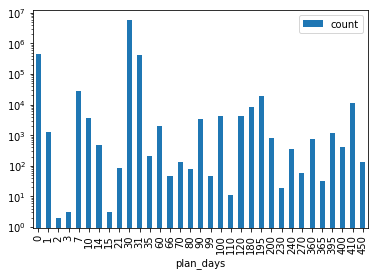

In [5]:
df_pdays_0 = df1.groupBy("plan_days").count()
df_pdays = df_pdays_0.sort("plan_days")

import matplotlib.pyplot as plt
import pandas as pd
df_pdays.toPandas().set_index('plan_days').plot(kind='bar', logy=True)
plt.show()

## plan_days = 0, 1, 2, 3

In [10]:
# plan_days = 0
df1.where('plan_days == 0').show(20)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|+++l/EXNMLTijfLBa...|  20150430|   20150619|        0|    39|         0|        149|         1|        0|
|++/UDNo9DLrxT8QVG...|  20150430|   20150623|        0|    39|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150331|   20150430|        0|    14|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150630|   20150731|        0|    14|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150731|   20150831|        0|    14|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150831|   20150930|        0|    14|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150930|   2

In [14]:
from pyspark.sql.functions import instr
filter1 = instr(col("msno"), "++3Z+W8OPnpbHYfrK") >= 1
df1.where(filter1).show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++3Z+W8OPnpbHYfrK...|  20150108|   20150209|       30|    41|       149|        149|         1|        0|
|++3Z+W8OPnpbHYfrK...|  20150208|   20150309|       30|    41|       149|        149|         1|        0|
|++3Z+W8OPnpbHYfrK...|  20150308|   20150409|       30|    41|       149|        149|         1|        0|
|++3Z+W8OPnpbHYfrK...|  20150408|   20150509|       30|    41|       149|        149|         1|        0|
|++3Z+W8OPnpbHYfrK...|  20150504|   20150609|        0|    41|         0|        129|         1|        0|
|++3Z+W8OPnpbHYfrK...|  20150504|   20150604|        0|    41|         0|        149|         1|        1|
|++3Z+W8OPnpbHYfrK...|  20150603|   2

In [5]:
from pyspark.sql.functions import max
df1.where(col('plan_days') == 0).select(max('trans_date')).show()

+---------------+
|max(trans_date)|
+---------------+
|       20151031|
+---------------+



In [13]:
df1.where('plan_days == 0').where('is_cancel == 0').groupBy('actual_paid').count().show(50)

+-----------+------+
|actual_paid| count|
+-----------+------+
|        799|    35|
|        300|    41|
|        350|     3|
|       1599|    27|
|        500|     4|
|        447|     5|
|         35|    84|
|        100|   138|
|        450|     8|
|        930|     7|
|       1000|     5|
|        129|  5208|
|       1200|     1|
|        400|     2|
|         50|     1|
|        480|    29|
|       1150|     2|
|        536|    47|
|        105|     5|
|        150|  2783|
|       1788|   319|
|        119|  5462|
|        149|419265|
|        131|    66|
|        894|   528|
|          0|   666|
|        134|   431|
+-----------+------+



In [20]:
df1.where('plan_days == 0').where('is_cancel == 0').where('actual_paid == 0').show(10)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|+1x90quayXba6Eab2...|  20150426|   20150525|        0|    40|         0|          0|         1|        0|
|+8y+m/RR1VFURbi/R...|  20150630|   20150731|        0|    33|         0|          0|         1|        0|
|+D4YNqVSXZ4O3yBwa...|  20150508|   20150607|        0|    40|         0|          0|         1|        0|
|+N/9ad7gKr90jGdyu...|  20150513|   20150612|        0|    40|         0|          0|         1|        0|
|+Wp9zLw0FV4XIuKTu...|  20150513|   20150612|        0|    40|         0|          0|         1|        0|
|+cZeFe1HVVkpWY7mi...|  20150507|   20150606|        0|    40|         0|          0|         1|        0|
|+chS7a9BpXF8Kpemi...|  20150503|   2

In [10]:
# plan_days = 1
df1.where(col('plan_days') == 1).show(10)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++4cUL0b9CfW8cj0A...|  20161028|   20161128|        1|    26|         0|          0|         0|        0|
|+1ckZac2hDVStzAfr...|  20161221|   20161228|        1|    26|         0|          0|         0|        0|
|+7xCGZydgLT8Rc9Bw...|  20170120|   20170225|        1|    26|         0|          0|         0|        0|
|+EICW7FnDAA4C8Bk2...|  20150809|   20150816|        1|    26|         0|          0|         0|        0|
|+EICW7FnDAA4C8Bk2...|  20150810|   20150910|        1|    26|         0|          0|         0|        0|
|+G9oaqNK6Vh/HXphx...|  20151016|   20151023|        1|    26|         0|          0|         0|        0|
|+KqXb8uyN5cZNqKO6...|  20160930|   2

In [21]:
from pyspark.sql.functions import instr
filter1 = instr(col("msno"), "+XWbRkRC94eFP6Gk+") >= 1
df1.where(filter1).show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|+XWbRkRC94eFP6Gk+...|  20151118|   20151217|       30|    41|        99|         99|         1|        0|
|+XWbRkRC94eFP6Gk+...|  20151119|   20160102|        1|    26|         0|          0|         0|        0|
|+XWbRkRC94eFP6Gk+...|  20151217|   20160201|       30|    41|        99|         99|         1|        0|
|+XWbRkRC94eFP6Gk+...|  20160117|   20160303|       30|    41|        99|         99|         1|        0|
|+XWbRkRC94eFP6Gk+...|  20160217|   20160401|       30|    41|        99|         99|         1|        0|
|+XWbRkRC94eFP6Gk+...|  20160317|   20160502|       30|    41|        99|         99|         1|        0|
|+XWbRkRC94eFP6Gk+...|  20160417|   2

In [7]:
df1.where(col('plan_days') == 1).where('method != 26').show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|Kw5J8WCp2WKzj2R9y...|  20151110|   20151111|        1|    38|         0|          0|         0|        0|
|jz0dRy6lAYY5T8Yuy...|  20151029|   20151030|        1|    38|         0|          0|         0|        0|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+



In [9]:
from pyspark.sql.functions import min, max
df1.where('plan_days == 1').select(max('trans_date'), max('list_price'), max('actual_paid'), 
                                   max('auto_renew'), max('is_cancel')).show(4)

+---------------+---------------+----------------+---------------+--------------+
|max(trans_date)|max(list_price)|max(actual_paid)|max(auto_renew)|max(is_cancel)|
+---------------+---------------+----------------+---------------+--------------+
|       20170228|              0|               0|              0|             0|
+---------------+---------------+----------------+---------------+--------------+



**conclusion:** 
* Records with `plan_days` = 1 have `method` = 26 or 38, `list_price` = `actual_paid` = 0, `auto_renew` = 0, `is_cancel` = 0. 
* They look like some kind of correction/update/prolong of subscription expire date.

In [58]:
# plan_days = 2
df1.where((col('plan_days') == 2) | (col('plan_days') == 3)).show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|6zx0HeEdbSL3AGTjt...|  20160412|   20160415|        3|    38|        15|         15|         0|        0|
|YSokopIuxo6RwqEQd...|  20160206|   20160209|        3|    38|        15|         15|         0|        0|
|YSokopIuxo6RwqEQd...|  20160722|   20160724|        2|    38|        10|         10|         0|        0|
|zNwGyygFpA/SMAxIO...|  20150824|   20151209|        2|    38|        10|         10|         0|        0|
|zNwGyygFpA/SMAxIO...|  20151219|   20151229|        3|    38|        15|         15|         0|        0|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+



## list_price = 0 

In [50]:
df1.where(col('list_price') == 0).show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|+++l/EXNMLTijfLBa...|  20150430|   20150619|        0|    39|         0|        149|         1|        0|
|++/UDNo9DLrxT8QVG...|  20150430|   20150623|        0|    39|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150331|   20150430|        0|    14|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150630|   20150731|        0|    14|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150731|   20150831|        0|    14|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150831|   20150930|        0|    14|         0|        149|         1|        0|
|++/ZHqwUNa7U21Qz+...|  20150930|   2

In [6]:
from pyspark.sql.functions import instr
filter1 = instr(col("msno"), "++6P09mCSJSh+Ft2p") >= 1
df1.where(filter1).show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++6P09mCSJSh+Ft2p...|  20150131|   20150313|       31|    39|       149|        149|         1|        0|
|++6P09mCSJSh+Ft2p...|  20150228|   20150413|       31|    39|       149|        149|         1|        0|
|++6P09mCSJSh+Ft2p...|  20150331|   20150513|       31|    39|       149|        149|         1|        0|
|++6P09mCSJSh+Ft2p...|  20150430|   20150613|        0|    39|         0|        149|         1|        0|
|++6P09mCSJSh+Ft2p...|  20150531|   20150713|       30|    39|       149|        149|         1|        0|
|++6P09mCSJSh+Ft2p...|  20150630|   20150813|       30|    39|       149|        149|         1|        0|
|++6P09mCSJSh+Ft2p...|  20150731|   2

## is_cancel 

In [26]:
df1.where('is_cancel == 1').show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++3Z+W8OPnpbHYfrK...|  20150504|   20150604|        0|    41|         0|        149|         1|        1|
|++4cUL0b9CfW8cj0A...|  20160302|   20160302|       30|    41|       149|        149|         1|        1|
|++4cUL0b9CfW8cj0A...|  20161028|   20161027|       30|    33|       149|        149|         1|        1|
|++5wYjoMgQHoRuD3G...|  20150512|   20150614|        0|    39|         0|        149|         1|        1|
|++95tJZADNg8U8HKb...|  20150425|   20150524|        0|    40|         0|        149|         1|        1|
|++9JUsaZioofS6Fb2...|  20170219|   20170310|       30|    37|       149|        149|         1|        1|
|++A8p4GrsTnMjI6hA...|  20150612|   2

In [28]:
from pyspark.sql.functions import instr
filter1 = instr(col("msno"), "++pSqgOqSB8laOm+R") >= 1
df1.where(filter1).show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++pSqgOqSB8laOm+R...|  20150105|   20150205|       30|    41|       149|        119|         1|        0|
|++pSqgOqSB8laOm+R...|  20150205|   20150305|       30|    41|       149|        119|         1|        0|
|++pSqgOqSB8laOm+R...|  20150305|   20150405|       30|    41|       149|        119|         1|        0|
|++pSqgOqSB8laOm+R...|  20150405|   20150505|       30|    41|       149|        119|         1|        0|
|++pSqgOqSB8laOm+R...|  20150505|   20150605|        0|    41|         0|        119|         1|        0|
|++pSqgOqSB8laOm+R...|  20150605|   20150705|       30|    41|       149|        149|         1|        0|
|++pSqgOqSB8laOm+R...|  20150606|   2

## expire_date >> trans_date 

In [34]:
from pyspark.sql.functions import floor

cri1 = col('plan_days') == 30
cri2 = col('plan_days') == 31
cri3 = (col('expire_date') - col('trans_date')) >= 200
cri4 = floor(col('expire_date') / 10000) == floor(col('trans_date') / 10000) 
df1.where(cri1 | cri2).where(cri3).where(cri4).show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++vWe05qm+bN0w2uE...|  20160110|   20160310|       30|    38|       149|        149|         0|        0|
|+/GXNtXWQVfKrEDqY...|  20170120|   20170322|       30|    36|       180|        180|         1|        0|
|+/UwoUi5+rNj/F6RO...|  20160819|   20161117|       30|    38|       149|        149|         0|        0|
|+/juzEnrbebfqNG77...|  20150724|   20150925|       30|    36|       150|        150|         0|        0|
|+/juzEnrbebfqNG77...|  20160128|   20160328|       30|    36|       150|        150|         0|        0|
|+/o1K0v6t2cGYPuuC...|  20170127|   20170328|       30|    36|       180|        180|         0|        0|
|+/pzcq2ScM/BS+F5I...|  20150228|   2

In [16]:
from pyspark.sql.functions import instr
filter1 = instr(col("msno"), "+/o1K0v6t2cGYPuuC") >= 1
df1.where(filter1).show(30)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|+/o1K0v6t2cGYPuuC...|  20150406|   20150506|       30|    36|       150|        150|         0|        0|
|+/o1K0v6t2cGYPuuC...|  20150524|   20150623|       30|    36|       150|        150|         0|        0|
|+/o1K0v6t2cGYPuuC...|  20150716|   20150815|       30|    36|       150|        150|         0|        0|
|+/o1K0v6t2cGYPuuC...|  20150822|   20150921|       30|    36|       150|        150|         0|        0|
|+/o1K0v6t2cGYPuuC...|  20151116|   20151216|       30|    36|       150|        150|         0|        0|
|+/o1K0v6t2cGYPuuC...|  20151221|   20160120|       30|    36|       150|        150|         0|        0|
|+/o1K0v6t2cGYPuuC...|  20160212|   2

In [19]:
from pyspark.sql.functions import floor

cri1 = col('plan_days') == 30
cri2 = col('plan_days') == 31
cri3 = floor(col('expire_date') / 10000) > floor(col('trans_date') / 10000) 
cri4 = floor(col('expire_date') / 100) - floor(col('trans_date') / 100) - 88 > 4
df1.where(cri1 | cri2).where(cri3).where(cri4).show(40)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++am6f+rLDE3gjQM7...|  20150114|   20160110|       30|    41|       129|        129|         1|        0|
|++am6f+rLDE3gjQM7...|  20150214|   20160207|       30|    41|       129|        129|         1|        0|
|++am6f+rLDE3gjQM7...|  20150314|   20160309|       30|    41|       129|        129|         1|        0|
|++am6f+rLDE3gjQM7...|  20150414|   20160408|       30|    41|       129|        129|         1|        0|
|++am6f+rLDE3gjQM7...|  20150514|   20160509|       30|    41|       129|        129|         1|        0|
|++am6f+rLDE3gjQM7...|  20150614|   20160608|       30|    41|       129|        129|         1|        0|
|++am6f+rLDE3gjQM7...|  20150714|   2

## actual_paid = 0

In [14]:
df1.where('actual_paid == 0').show(20)

+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|                msno|trans_date|expire_date|plan_days|method|list_price|actual_paid|auto_renew|is_cancel|
+--------------------+----------+-----------+---------+------+----------+-----------+----------+---------+
|++4cUL0b9CfW8cj0A...|  20161028|   20161128|        1|    26|         0|          0|         0|        0|
|++A8p4GrsTnMjI6hA...|  20151221|   20160120|       30|    30|       149|          0|         1|        0|
|++A8p4GrsTnMjI6hA...|  20160226|   20160325|       30|    30|       149|          0|         1|        0|
|++N9C3T2DFC2uRZ9L...|  20161025|   20161101|        7|    35|         0|          0|         0|        0|
|++Tp41swlnwrt2eLT...|  20150602|   20150615|        7|    35|         0|          0|         0|        0|
|++hm6Yp8JLZQ12NV5...|  20161101|   20161108|        7|    35|         0|          0|         0|        0|
|++lJ3R8mLL7PpfIFA...|  20150601|   2

## plan_days vs. actual_paid

In [10]:
from pyspark.sql.functions import expr, countDistinct, col

df1.where("plan_days > 0") \
   .groupBy("actual_paid") \
   .agg(expr("count(plan_days)"), countDistinct(col("plan_days")), 
        expr("min(plan_days)"), expr("max(plan_days)")).show(50)

+-----------+----------------+-------------------------+--------------+--------------+
|actual_paid|count(plan_days)|count(DISTINCT plan_days)|min(plan_days)|max(plan_days)|
+-----------+----------------+-------------------------+--------------+--------------+
|        799|            1076|                        1|           180|           180|
|        210|              15|                        1|            30|            30|
|        596|              26|                        2|           120|           180|
|        300|            1604|                        2|            60|            90|
|        350|             135|                        1|            70|            70|
|       1599|            1514|                        2|           395|           400|
|          1|              14|                        2|            30|            90|
|        699|             458|                        1|           180|           180|
|        760|               1|             

## method

In [6]:
df2 = df1.select("method", "plan_days", "list_price", "actual_paid")

In [12]:
df2.groupBy("method", "plan_days").count() \
   .orderBy("method").show(40)

+------+---------+-----+
|method|plan_days|count|
+------+---------+-----+
|     2|        0|    1|
|     2|       30|    1|
|     2|      195|    7|
|     2|      410|    1|
|     3|        0|    2|
|     3|      195|   49|
|     4|      195|    2|
|     5|      410|   33|
|     5|        0|    4|
|     5|      195|   22|
|     6|      410|   13|
|     6|        0|    3|
|     6|      195|   31|
|     6|      395|    5|
|     6|      180|    7|
|     8|        0|    6|
|     8|      410|   32|
|     8|      195|  130|
|    10|       31|  166|
|    10|        0|   31|
|    10|       30|  861|
|    11|       31|  276|
|    11|       30| 1353|
|    11|        0|   54|
|    12|        0|   23|
|    12|      195|  335|
|    12|      400|    4|
|    12|      410|  270|
|    13|        0|   20|
|    13|      410|  233|
|    13|      195|  805|
|    14|        0| 2766|
|    14|       30| 7188|
|    15|      195|   45|
|    15|        0|    4|
|    15|      410|   56|
|    15|      180|   28|
